In [4]:
# import numpy as np
# import auxiliary as au
# from matplotlib import pyplot as plt
from scipy import io
import os
# import sys
# import h5py
# import time
# import random
# import datetime
from bma_merge import bma
from auxiliary_merge import *


def empirical_cdf(data, probtar):
    # data: vector of data
    data2 = data[~np.isnan(data)]
    if len(data2) > 0:
        ds = np.sort(data2)
        probreal = np.arange(len(data2)) / (len(data2) + 1)
        ecdf_out = np.interp(probtar, probreal, ds)
    else:
        ecdf_out = np.nan * np.zeros(len(probtar))
    return ecdf_out


def cdf_correction(cdf_ref, value_ref, cdf_raw, value_raw, value_tar):
    prob_tar = np.interp(value_tar, value_raw, cdf_raw)
    value_out = np.interp(prob_tar, cdf_ref, value_ref)
    return value_out


def calculate_anomaly(datatar, dataref, hwsize, amode, upbound=5, lowbound=0.2):
    # datatar, dataref: 2D [nstn, ntime]
    # amode: anomaly mode ('ratio' or 'diff')
    # hwsize: define time window (2*hwsize+1) used to calculate ratio (as ratio for a specific day is too variable)
    # upbound/lowbound: upper and lower limitation of ratio/difference
    if np.ndim(datatar) == 1:  # only one time step
        datatar = datatar[:, np.newaxis]
        dataref = dataref[:, np.newaxis]

    nstn, ntime = np.shape(datatar)
    if ntime < hwsize * 2 + 1:
        print('The window size is larger than time steps when calculating ratio between tar and ref datasets')
        print('Please set a smaller hwsize')
        sys.exit()

    anom = np.ones([nstn, ntime])

    for i in range(ntime):
        if i < hwsize:
            windex = np.arange(hwsize * 2 + 1)
        elif i >= ntime - hwsize:
            windex = np.arange(ntime - hwsize * 2 - 1, ntime)
        else:
            windex = np.arange(i - hwsize, i + hwsize + 1)
        dtari = np.nanmean(datatar[:, windex], axis=1)
        drefi = np.nanmean(dataref[:, windex], axis=1)

        if amode == 'ratio':
            temp = drefi / dtari
            temp[(dtari == 0) & (drefi == 0)] = 1
            anom[:, i] = temp
        elif amode == 'diff':
            anom[:, i] = drefi - dtari
        else:
            sys.exit('Unknow amode. Please use either ratio or diff')

    anom[anom > upbound] = upbound
    anom[anom < lowbound] = lowbound
    return anom


def findnearstn(stnlat, stnlon, tarlat, tarlon, nearnum, noself):
    # only use lat/lon to find near stations without considering distance in km
    # stnlat/stnlon: 1D
    # tarlat/tarlon: 1D or 2D
    # noself: 1--stnlat and tarlat have overlapped stations, which should be excluded from stnlat

    stnll = np.zeros([len(stnlat), 2])
    stnll[:, 0] = stnlat
    stnll[:, 1] = stnlon

    if len(np.shape(tarlat)) == 1:
        num = len(tarlat)
        nearstn_loc = -1 * np.ones([num, nearnum], dtype=int)
        nearstn_dist = -1 * np.ones([num, nearnum], dtype=float)
        for i in range(num):
            if np.isnan(tarlat[i]) or np.isnan(tarlon[i]):
                continue
            tari = np.array([tarlat[i], tarlon[i]])
            dist = au.distance(tari, stnll)
            dist[np.isnan(dist)] = 1000000000
            if noself == 1:
                dist[dist == 0] = np.inf  # may not be perfect, but work for SCDNA
            indi = np.argsort(dist)
            nearstn_loc[i, :] = indi[0:nearnum]
            nearstn_dist[i, :] = dist[nearstn_loc[i, :]]
    elif len(np.shape(tarlat)) == 2:
        nrows, ncols = np.shape(tarlat)
        nearstn_loc = -1 * np.ones([nrows, ncols, nearnum], dtype=int)
        nearstn_dist = -1 * np.ones([nrows, ncols, nearnum], dtype=float)
        for r in range(nrows):
            print('rows', r, nrows)
            for c in range(ncols):
                if np.isnan(tarlat[r, c]) or np.isnan(tarlon[r, c]):
                    continue
                tari = np.array([tarlat[r, c], tarlon[r, c]])
                dist = au.distance(tari, stnll)
                dist[np.isnan(dist)] = 1000000000
                indi = np.argsort(dist)
                nearstn_loc[r, c, :] = indi[0:nearnum]
                nearstn_dist[r, c, :] = dist[nearstn_loc[r, c, :]]
    else:
        print('The dimensions of tarlat or tarlon are larger than 2')
        sys.exit()

    return nearstn_loc, nearstn_dist


def error_correction_stn(corrmode, stndata_i2_near, nearstn_weighti2, readata_stn_i2, readata_i2_near, ecdf_prob):
    # corrmode: QM, Mul_Climo, Mul_Daily, Add_Climo, Add_Climo
    nearstn_numi2, ntimes = np.shape(stndata_i2_near)
    corrdata_out = np.zeros(ntimes)
    if corrmode == 'QM':
        cdf_rea = empirical_cdf(readata_stn_i2, ecdf_prob)
        for j in range(nearstn_numi2):
            cdf_ref = empirical_cdf(stndata_i2_near[j, :], ecdf_prob)
            qmdata_rj = cdf_correction(ecdf_prob, cdf_ref, ecdf_prob, cdf_rea, readata_stn_i2)
            corrdata_out = corrdata_out + qmdata_rj * nearstn_weighti2[j]
        corrdata_out = corrdata_out / np.sum(nearstn_weighti2)
    elif corrmode[0:3] == 'Mul' or corrmode[0:3] == 'Add':
        # multplicative correction or additive correction
        if corrmode[4:] == 'Daily':
            dtar = readata_i2_near
            dref = stndata_i2_near
        elif corrmode[4:] == 'Climo':
            dtar = np.nanmean(readata_i2_near, axis=1)
            dtar = dtar[:, np.newaxis]
            dref = np.nanmean(stndata_i2_near, axis=1)
            dref = dref[:, np.newaxis]
        else:
            sys.exit('Unknown corrmode')
        if corrmode[0:3] == 'Mul':
            corrfactor_i2_near = calculate_anomaly(dtar, dref, 0, 'ratio', 10, 0)  # 10 is default max limit
        else:
            corrfactor_i2_near = calculate_anomaly(dtar, dref, 0, 'diff', 9999, -9999)
        weight_use = np.tile(nearstn_weighti2, (np.shape(corrfactor_i2_near)[1], 1)).T
        weight_use[np.isnan(corrfactor_i2_near)] = np.nan
        corrfactor_i2 = np.nansum(corrfactor_i2_near * weight_use, axis=0) / np.nansum(weight_use)
        if corrmode[0:3] == 'Mul':
            corrdata_out = readata_stn_i2 * corrfactor_i2
        else:
            corrdata_out = readata_stn_i2 + corrfactor_i2
    else:
        sys.exit('Unknown corrmode')

    return corrdata_out


def error_correction(dataori, anomaly, mode='ratio'):
    # default: time is the last dimension
    if mode == 'ratio':
        datacorr = dataori * anomaly
    elif mode == 'diff':
        datacorr = dataori + anomaly
    else:
        sys.exit('Wrong error correction mode')
    return datacorr


def calweight(obs, rea, mode, preprocess=True):
    ntimes, reanum = np.shape(rea)
    if preprocess:
        # delete the nan values
        ind_nan = np.isnan(obs + np.sum(rea, axis=1))
        obs = obs[~ind_nan]
        rea = rea[~ind_nan, :]

    if len(obs) > 2:
        if mode == 'BMA':
            weight, sigma, sigma_s = bma(rea, obs)
        else:
            met = np.zeros(reanum)
            if mode == 'RMSE':
                for i in range(reanum):
                    met[i] = np.sqrt(np.sum(np.square(obs - rea[:, i])) / len(obs))  # RMSE
                weight = 1 / (met ** 2)
            elif mode == 'CC':
                for i in range(reanum):
                    met[i] = np.corrcoef(obs, rea[:, i])[0][1]
                weight = (met ** 2)
    else:
        weight = np.ones(reanum) / reanum
    if np.any(np.isnan(weight)):
        weight = np.ones(reanum) / reanum
    return weight


def weightmerge(data, weight):
    if np.ndim(data) == 2:
        weight2 = weight.copy()
        weight2[np.isnan(data)] = np.nan
        dataout = np.nansum(data * weight2, axis=1) / np.nansum(weight2, axis=1)
    elif np.ndim(data) == 3:
        weight2 = weight.copy()
        weight2[np.isnan(data)] = np.nan
        dataout = np.nansum(data * weight2, axis=2) / np.nansum(weight2, axis=2)
        dataout[np.isnan(data[:, :, 0])] = np.nan
    return dataout


def correction_merge_stn(stndata, ecdf_prob, readata_stn, nearstn_loc, nearstn_dist, var, corrmode, weightmode):
    # corrmode = 'QM'  # QM, Mul_Climo, Mul_Daily, Add_Climo, Add_Climo
    # use 2-layer cross-validation to estimate the weight and independent data of merge/correction data
    reanum, nstn, ntimes = np.shape(readata_stn)

    # initialization
    reacorr_stn = np.nan * np.zeros([reanum, nstn, ntimes], dtype=np.float32)  # corrected reanalysis data
    reamerge_weight_stn = np.nan * np.zeros([nstn, reanum], dtype=np.float32)  # weight used to obtain reamerge_stn
    reamerge_stn = np.nan * np.zeros([nstn, ntimes], dtype=np.float32)  # merged reanalysis at station points

    for i1 in range(nstn):  # layer-1
        if np.mod(i1, 1000) == 0:
            print(i1)
        if np.isnan(stndata[i1, 0]):
            continue
        nearstn_loci1 = nearstn_loc[i1, :]
        nearstn_disti1 = nearstn_dist[i1, :]
        induse = nearstn_loci1 > -1
        nearstn_loci1 = nearstn_loci1[induse]
        nearstn_disti1 = nearstn_disti1[induse]
        nearstn_numi1 = len(nearstn_loci1)
        if nearstn_numi1 == 0:
            sys.exit('No near station for the target station (layer-1)')

        # start layer-2
        reamerge_weight_i2 = np.zeros([nearstn_numi1, reanum])
        for i2 in range(nearstn_numi1):  # layer-2
            nearstn_loci2 = nearstn_loc[nearstn_loci1[i2], :]
            nearstn_disti2 = nearstn_dist[nearstn_loci1[i2], :]
            induse = (nearstn_loci2 > -1) & (nearstn_loci2 != i1)  # i1 should be independent
            nearstn_loci2 = nearstn_loci2[induse]
            nearstn_disti2 = nearstn_disti2[induse]
            maxd = np.max([np.max(nearstn_disti2) + 1, 100])
            nearstn_weighti2 = au.distanceweight(nearstn_disti2, maxd, 3)
            nearstn_weighti2 = nearstn_weighti2 / np.sum(nearstn_weighti2)

            nearstn_numi2 = len(nearstn_loci2)
            if nearstn_numi2 == 0:
                sys.exit('No near station for the target station (layer-1)')

            # data at i2 station
            stndata_i2 = stndata[nearstn_loci1[i2], :]
            stndata_i2_near = stndata[nearstn_loci2, :]
            readata_stn_i2 = readata_stn[:, nearstn_loci1[i2], :]
            readata_i2_near = readata_stn[:, nearstn_loci2, :]

            # error correction for each reanalysis dataset using different modes
            corrdata_i2 = np.zeros([ntimes, reanum])
            for r in range(reanum):
                corrdata_i2[:, r] = error_correction_stn(corrmode, stndata_i2_near, nearstn_weighti2,
                                                         readata_stn_i2[r, :], readata_i2_near[r, :, :], ecdf_prob)

            # calculate merging weight for i2
            if weightmode == 'BMA' and var == 'prcp':
                # exclude zero precipitation and carry out box-cox transformation
                datatemp = np.zeros([ntimes, reanum + 1])
                datatemp[:, 0] = stndata_i2
                datatemp[:, 1:] = corrdata_i2
                ind0 = np.sum(datatemp >= 0.01, axis=1) == (reanum + 1)  # positive hit events
                dobs = box_cox_transform(stndata_i2[ind0])
                drea = box_cox_transform(corrdata_i2[ind0, :])
            else:
                dobs = stndata_i2
                drea = corrdata_i2
            reamerge_weight_i2[i2, :] = calweight(dobs, drea, weightmode)
        # end layer-2

        stndata_i1 = stndata[i1, :]
        stndata_i1_near = stndata[nearstn_loci1, :]
        readata_stn_i1 = readata_stn[:, i1, :]
        readata_i1_near = readata_stn[:, nearstn_loci1, :]
        maxd = np.max([np.max(nearstn_disti1) + 1, 100])
        nearstn_weighti1 = au.distanceweight(nearstn_disti1, maxd, 3)
        nearstn_weighti1 = nearstn_weighti1 / np.sum(nearstn_weighti1)

        # get corrected data at i1
        corrdata_i1 = np.zeros([ntimes, reanum])
        for r in range(reanum):
            corrdata_i1[:, r] = error_correction_stn(corrmode, stndata_i1_near, nearstn_weighti1,
                                                     readata_stn_i1[r, :], readata_i1_near[r, :, :], ecdf_prob)
        reacorr_stn[:, i1, :] = corrdata_i1.T

        # get merging weight at i1 and merge reanalysis
        # note: this weight is just for independent merging so we can estimate the error of merged reanalysis
        # the real weight will be estimated using just one-layer cross-validation
        weight_use = np.tile(nearstn_weighti1, (reanum, 1)).T
        weight_i1 = np.sum(weight_use * reamerge_weight_i2, axis=0)
        weight_i1 = weight_i1 / np.sum(weight_i1)

        weight_use = np.tile(weight_i1, (ntimes, 1))
        weight_use[np.isnan(corrdata_i1)] = np.nan
        # if weightmode == 'BMA' and var == 'prcp':
        #     # the merging after box-cox transformation underestimates precipitation in southeast US
        #     # and the rationality of box-cox should be revisited
        #     reamerge_stni1 = np.nansum(weight_use * box_cox_transform(corrdata_i1), axis=1) / np.nansum(weight_use, axis=1)
        #     reamerge_stni1 = box_cox_recover(reamerge_stni1)
        # else:
        #     reamerge_stni1 = np.nansum(weight_use * corrdata_i1, axis=1) / np.nansum(weight_use, axis=1)
        reamerge_stni1 = np.nansum(weight_use * corrdata_i1, axis=1) / np.nansum(weight_use, axis=1)
        reamerge_stn[i1, :] = reamerge_stni1

        # get the final merging weight
        if weightmode == 'BMA' and var == 'prcp':
            # exclude zero precipitation and carry out box-cox transformation
            datatemp = np.zeros([ntimes, reanum + 1])
            datatemp[:, 0] = stndata_i1
            datatemp[:, 1:] = corrdata_i1
            ind0 = np.sum(datatemp >= 0.01, axis=1) == (reanum + 1)  # positive hit events
            dobs = box_cox_transform(stndata_i1[ind0])
            drea = box_cox_transform(corrdata_i1[ind0, :])
        else:
            dobs = stndata_i1
            drea = corrdata_i1
        reamerge_weight_stn[i1, :] = calweight(dobs, drea, weightmode)

    # note: reamerge_weight_stn is the final merging weight, and reacorr_stn is the final corrected data
    # but reamerge_stn is just independent merging estimates which is calculated from 2-layer cross validation
    return reamerge_stn, reamerge_weight_stn, reacorr_stn


def correction_rea(stndata, ecdf_prob, readata_stn, nearstn_loc, nearstn_dist, corrmode):
    # compare the performance of daily-scale multiplicative correction and QM
    reanum, nstn, ntimes = np.shape(readata_stn)
    nprob = len(ecdf_prob)

    # initialization
    reacorr = np.nan * np.zeros([reanum, nstn, ntimes], dtype=np.float32)  # corrected reanalysis data

    for i1 in range(nstn):  # layer-1
        # if np.mod(i1, 1000) == 0:
        #     print(i1)
        if np.isnan(stndata[i1, 0]):
            continue

        nearstn_loci1 = nearstn_loc[i1, :]
        nearstn_disti1 = nearstn_dist[i1, :]
        induse = nearstn_loci1 > -1
        nearstn_loci1 = nearstn_loci1[induse]
        nearstn_disti1 = nearstn_disti1[induse]
        nearstn_numi1 = len(nearstn_loci1)
        if nearstn_numi1 == 0:
            sys.exit('No near station for the target station (layer-1)')

        stndata_i1_near = stndata[nearstn_loci1, :]
        readata_stn_i1 = readata_stn[:, i1, :]
        readata_i1_near = readata_stn[:, nearstn_loci1, :]
        maxd = np.max([np.max(nearstn_disti1) + 1, 100])
        nearstn_weighti1 = au.distanceweight(nearstn_disti1, maxd, 3)
        nearstn_weighti1 = nearstn_weighti1 / np.sum(nearstn_weighti1)

        # get corrected data at i1
        corrdata_i1 = np.zeros([ntimes, reanum])
        for r in range(reanum):
            corrdata_i1[:, r] = error_correction_stn(corrmode, stndata_i1_near, nearstn_weighti1,
                                                     readata_stn_i1[r, :], readata_i1_near[r, :, :], ecdf_prob)
        reacorr[:, i1, :] = corrdata_i1.T

    return reacorr


def correction_merge_grid(stndata, readata_raw, readata_stn, reacorr_stn, reamerge_stn, reamerge_weight_stn,
                          neargrid_loc,
                          neargrid_dist, merge_choice, mask, hwsize, corrmode, anombound, var, weightmode):
    nrows, ncols, nearnum = np.shape(neargrid_loc)
    reanum, nstn, nday = np.shape(readata_stn)

    neargrid_loc = neargrid_loc.copy()
    neargrid_dist = neargrid_dist.copy()
    mask2 = np.tile(mask[:, :, np.newaxis], (1, 1, nearnum))
    neargrid_loc[mask2 != 1] = -1
    neargrid_dist[mask2 != 1] = np.nan
    del mask2

    # correct raw gridded reanalysis data using all stations
    corr_data = np.nan * np.zeros([reanum, nrows, ncols, nday], dtype=np.float32)
    for rr in range(reanum):
        # calculate correction ratio at all station point
        anom_ori = calculate_anomaly(readata_stn[rr, :, :], stndata[:, :],
                                     hwsize, corrmode, upbound=anombound[1], lowbound=anombound[0])
        anom_ext = extrapolation(anom_ori, neargrid_loc, neargrid_dist)
        corr_data[rr, :, :, :] = error_correction(readata_raw[rr, :, :, :], anom_ext, mode=corrmode)

    # first error estimation
    corr_error = np.nan * np.zeros([reanum, nrows, ncols, nday], dtype=np.float32)
    for rr in range(reanum):
        corr_error[rr, :, :, :] = extrapolation(reacorr_stn[rr, :, :] - stndata, neargrid_loc, neargrid_dist)
    merge_error0 = extrapolation(reamerge_stn - stndata, neargrid_loc, neargrid_dist)

    if var == 'prcp' and weightmode == 'BMA':
        corr_data = box_cox_transform(corr_data)
        stndata = box_cox_transform(stndata)
        reamerge_stn = box_cox_transform(reamerge_stn)
        reacorr_stn = box_cox_transform(reacorr_stn)

        # correction error in normal space (box-cox)
        corr_error_bc = np.nan * np.zeros([reanum, nrows, ncols, nday], dtype=np.float32)
        for rr in range(reanum):
            corr_error_bc[rr, :, :, :] = extrapolation(reacorr_stn[rr, :, :] - stndata, neargrid_loc, neargrid_dist)
        merge_error0_bc = extrapolation(reamerge_stn - stndata, neargrid_loc, neargrid_dist)

    # merge reanalysis data
    merge_data = np.nan * np.zeros([nrows, ncols, nday], dtype=np.float32)
    weight_grid = extrapolation(reamerge_weight_stn, neargrid_loc, neargrid_dist)
    for i in range(nday):
        datain = np.zeros([nrows, ncols, reanum])
        for rr in range(reanum):
            datain[:, :, rr] = corr_data[rr, :, :, i]
        merge_data[:, :, i] = weightmerge(datain, weight_grid)

    # calculate the error of merged data (this is actually independent with merged data estimation)
    merge_error = np.nan * np.zeros([nrows, ncols, nday], dtype=np.float32)
    for r in range(nrows):
        for c in range(ncols):
            if not np.isnan(mask[r, c]):
                chi = merge_choice[r, c]
                if chi > 0:
                    merge_error[r, c, :] = corr_error[chi - 1, r, c, :]
                else:
                    merge_error[r, c, :] = merge_error0[r, c, :]

    if var == 'prcp' and weightmode == 'BMA':
        merge_error_bc = np.nan * np.zeros([nrows, ncols, nday], dtype=np.float32)
        for r in range(nrows):
            for c in range(ncols):
                if not np.isnan(mask[r, c]):
                    chi = merge_choice[r, c]
                    if chi > 0:
                        merge_error_bc[r, c, :] = corr_error_bc[chi - 1, r, c, :]
                    else:
                        merge_error_bc[r, c, :] = merge_error0_bc[r, c, :]

    if var == 'prcp' and weightmode == 'BMA':
        merge_error_out = [''] * 2
        merge_error_out[0] = merge_error
        merge_error_out[1] = merge_error_bc
        merge_data = box_cox_recover(merge_data)
        corr_data = box_cox_recover(corr_data)
    else:
        merge_error_out = ['']
        merge_error_out[0] = merge_error
    return corr_data, corr_error, merge_data, merge_error_out


def mse_error(stndata, reacorr_stn, reamerge_stn, neargrid_loc, neargrid_dist, merge_choice, mask, var, pcptrans=False):
    nrows, ncols, nearnum = np.shape(neargrid_loc)
    reanum, nstn, nday = np.shape(reacorr_stn)

    neargrid_loc = neargrid_loc.copy()
    neargrid_dist = neargrid_dist.copy()
    mask2 = np.tile(mask[:, :, np.newaxis], (1, 1, nearnum))
    neargrid_loc[mask2 != 1] = -1
    neargrid_dist[mask2 != 1] = np.nan
    del mask2

    if var == 'prcp' and pcptrans == True:
        stndata = box_cox_transform(stndata)
        reamerge_stn = box_cox_transform(reamerge_stn)
        reacorr_stn = box_cox_transform(reacorr_stn)

    corr_error = np.nan * np.zeros([reanum, nrows, ncols, nday], dtype=np.float32)
    for rr in range(reanum):
        corr_error[rr, :, :, :] = extrapolation((reacorr_stn[rr, :, :] - stndata) ** 2, neargrid_loc, neargrid_dist)
    corr_error = corr_error ** 0.5
    merge_error0 = extrapolation((reamerge_stn - stndata) ** 2, neargrid_loc, neargrid_dist)
    merge_error0 = merge_error0 ** 0.5

    mse_error = np.nan * np.zeros([nrows, ncols, nday], dtype=np.float32)
    for r in range(nrows):
        for c in range(ncols):
            if not np.isnan(mask[r, c]):
                chi = merge_choice[r, c]
                if chi > 0:
                    mse_error[r, c, :] = corr_error[chi - 1, r, c, :]
                else:
                    mse_error[r, c, :] = merge_error0[r, c, :]

    return mse_error


########################################################################################################################
# time periods and methods
# var = 'prcp'  # ['prcp', 'tmean', 'trange']: this should be input from sbtach script
# weightmode for merging: (CC, RMSE, BMA): Weight = CC**2, or Weight = 1/RMSE**2, or Weight = BMA
# corrmode: QM, Mul_Climo, Mul_Daily, Add_Climo, Add_Climo
# year range for merging. note weight is calculated using all data not limited by year

# read from inputs
# var = sys.argv[1]
# weightmode = sys.argv[2]
# corrmode =  sys.argv[3]
# y1 = int(sys.argv[4])
# y2 = int(sys.argv[5])
# year = [y1, y2]

# embeded
var = 'prcp'
weightmode = 'BMA'
corrmode = 'QM'
y1 = 2017
y2 = 2018
year = [y1, y2]

print('var is ', var)
print('weightmode is ', weightmode)
print('years are ', y1, y2)

########################################################################################################################

# basic settings
lontar = np.arange(-180 + 0.05, -50, 0.1)
lattar = np.arange(85 - 0.05, 5, -0.1)
nearnum = 10  # the number of nearby stations used to extrapolate points to grids (for correction and merging)
anombound = [0.2, 10]  # upper and lower bound when calculating the anomaly for correction
prefix = ['ERA5_', 'MERRA2_', 'JRA55_']

### Local Mac settings
# input files/paths
gmet_stnfile = '/Users/localuser/Research/EMDNA/basicinfo/stnlist_whole.txt'
gmet_stndatafile = '/Users/localuser/Research/EMDNA/stndata_whole.npz'
file_mask = './DEM/NA_DEM_010deg_trim.mat'
path_readowngrid = ['/Users/localuser/Research/EMDNA/downscale/ERA5',  # downscaled gridded data
                    '/Users/localuser/Research/EMDNA/downscale/MERRA2',
                    '/Users/localuser/Research/EMDNA/downscale/JRA55']
file_readownstn = ['/Users/localuser/Research/EMDNA/downscale/ERA5_downto_stn_nearest.npz', # downscaled to stn points
                   '/Users/localuser/Research/EMDNA/downscale/MERRA2_downto_stn_nearest.npz',
                   '/Users/localuser/Research/EMDNA/downscale/JRA55_downto_stn_nearest.npz']
# file_readownstn = ['/Users/localuser/Research/EMDNA/downscale/JRA55_downto_stn_nearest.npz']

# output files/paths (can also be used as inputs once generated)
near_path = '/Users/localuser/Research/EMDNA/correction'  # path to save near station for each grid/cell
path_reacorr = '/Users/localuser/Research/EMDNA/correction' # path to save corrected reanalysis data at station points
path_merge = '/Users/localuser/Research/EMDNA/merge'
path_ecdf = '/Users/localuser/Research/EMDNA/merge/ECDF'
### Local Mac settings


# ### Plato settings
# # input files/paths
# gmet_stnfile = '/datastore/GLOBALWATER/CommonData/EMDNA/StnGridInfo/stnlist_whole.txt'
# gmet_stndatafile = '/datastore/GLOBALWATER/CommonData/EMDNA/stndata_whole.npz'
# file_mask = '/datastore/GLOBALWATER/CommonData/EMDNA/DEM/NA_DEM_010deg_trim.mat'
# path_readowngrid = ['/datastore/GLOBALWATER/CommonData/EMDNA/ERA5_day_ds',  # downscaled gridded data
#                    '/datastore/GLOBALWATER/CommonData/EMDNA/MERRA2_day_ds',
#                    '/datastore/GLOBALWATER/CommonData/EMDNA/JRA55_day_ds']
# file_readownstn = ['/datastore/GLOBALWATER/CommonData/EMDNA/ERA5_day_ds/ERA5_downto_stn_GWR.npz', # downscaled to stn points
#                    '/datastore/GLOBALWATER/CommonData/EMDNA/MERRA2_day_ds/MERRA2_downto_stn_GWR.npz',
#                    '/datastore/GLOBALWATER/CommonData/EMDNA/JRA55_day_ds/JRA55_downto_stn_GWR.npz']
#
# # output files/paths (can also be used as inputs once generated)
# near_path = '/home/gut428/ReanalysisCorrMerge'  # path to save near station for each grid/cell
# path_reacorr = '/home/gut428/ReanalysisCorrMerge/Reanalysis_corr'  # path to save corrected reanalysis data at station points
# path_merge = '/home/gut428/ReanalysisCorrMerge/Reanalysis_merge'
# path_ecdf = '/home/gut428/ReanalysisCorrMerge/ECDF'
# ### Plato settings


near_stnfile = near_path + '/near_stn_' + var + '.npz'
near_gridfile = near_path + '/near_grid_' + var + '.npz'
file_corrmerge_stn = path_merge + '/mergecorr_stn_' + var + '_GWRQM_' + weightmode + '.npz'  # file of indepedent corrected/merging data and merging weights
file_mergechoice = path_merge + '/mergechoice_' + var + '_' + weightmode + '.npz'


var is  prcp
weightmode is  BMA
years are  2017 2018


In [2]:
########################################################################################################################

# basic processing
print('start basic processing')

# mask
mask = io.loadmat(file_mask)
mask = mask['DEM']
mask[~np.isnan(mask)] = 1  # 1: valid pixels

# meshed lat/lon of the target region
reanum = len(file_readownstn)
nrows, ncols = np.shape(mask)
lontarm, lattarm = np.meshgrid(lontar, lattar)
lontarm[np.isnan(mask)] = np.nan
lattarm[np.isnan(mask)] = np.nan

# date list
date_list, date_number = m_DateList(1979, 2018, 'ByYear')

# load observations for all stations
datatemp = np.load(gmet_stndatafile)
stndata = datatemp[var + '_stn']
stnlle = datatemp['stn_lle']
nstn, ntimes = np.shape(stndata)
del datatemp

# probability bins for QM
binprob = 500
ecdf_prob = np.arange(0, 1 + 1 / binprob, 1 / binprob)


start basic processing


In [6]:
########################################################################################################################

# find near stations
# find near stations for all stations
if os.path.isfile(near_stnfile):
    print('load near station information for points')
    with np.load(near_stnfile) as datatemp:
        nearstn_loc = datatemp['nearstn_loc']
        nearstn_dist = datatemp['nearstn_dist']
    del datatemp
else:
    print('find near stations for station points')
    stnllein = stnlle.copy()
    stnllein[np.isnan(stndata[:, 0]), :] = np.nan
    nearstn_loc, nearstn_dist = findnearstn \
        (stnllein[:, 0], stnllein[:, 1], stnllein[:, 0], stnllein[:, 1], nearnum, 1)
    np.savez_compressed(near_stnfile, nearstn_loc=nearstn_loc, nearstn_dist=nearstn_dist)

# find near stations for all grids
if os.path.isfile(near_gridfile):
    print('load near station information for grids')
    with np.load(near_gridfile) as datatemp:
        neargrid_loc = datatemp['neargrid_loc']
        neargrid_dist = datatemp['neargrid_dist']
else:
    print('find near stations for grids')
    stnlle_in = stnlle.copy()
    stnlle_in[np.isnan(stndata[:, 0]), 0:2] = np.nan
    neargrid_loc, neargrid_dist = findnearstn(stnlle_in[:, 0], stnlle_in[:, 1], lattarm, lontarm, nearnum, 0)
    np.savez_compressed(near_gridfile,neargrid_loc=neargrid_loc,neargrid_dist=neargrid_dist)

load near station information for points
load near station information for grids


In [13]:
# ########################################################################################################################

# # load downscaled reanalysis at station points
# print('load downscaled reanalysis data at station points')
# readata_stn = np.nan * np.zeros([reanum, nstn, ntimes], dtype=np.float32)
# for rr in range(reanum):
#     dr = np.load(file_readownstn[rr])
#     temp = dr[var + '_readown']
#     # if prefix[rr] == 'MERRA2_':  # unify the time length of all data as MERRA2 lacks 1979
#     #     add = np.nan * np.zeros([nstn, 365])
#     #     temp = np.concatenate((add, temp), axis=1)
#     readata_stn[rr, :, :] = temp
#     del dr, temp
# if var == 'prcp':
#     readata_stn[readata_stn < 0] = 0

In [14]:
# get merged and corrected reanalysis data at all station points using two-layer cross-validation
if os.path.isfile(file_corrmerge_stn):
    print('load independent merged/corrected data at station points')
    datatemp = np.load(file_corrmerge_stn)
    reamerge_stn = datatemp['reamerge_stn']
    reamerge_weight_stn = datatemp['reamerge_weight_stn']
    reacorr_stn = datatemp['reacorr_stn']
    del datatemp
else:
    reamerge_stn = np.nan * np.zeros([nstn, ntimes], dtype=np.float32)
    reamerge_weight_stn = np.nan * np.zeros([12, nstn, reanum], dtype=np.float32)
    reacorr_stn = np.nan * np.zeros([reanum, nstn, ntimes], dtype=np.float32)
    # for each month
    for m in range(12):
        print('month', m + 1)
        indm = date_number['mm'] == (m + 1)
        reamerge_stnm, reamerge_weight_stnm, reacorr_stnm = \
            correction_merge_stn(stndata[:, indm], ecdf_prob, readata_stn[:, :, indm], nearstn_loc, nearstn_dist,
                                 var, corrmode, weightmode)
        reamerge_stn[:, indm] = reamerge_stnm
        reacorr_stn[:, :, indm] = reacorr_stnm
        reamerge_weight_stn[m, :, :] = reamerge_weight_stnm

    # the variables are independent with their concurrent stations. thus, station data can be used to evaluate them
    np.savez_compressed(file_corrmerge_stn, reamerge_stn=reamerge_stn, reamerge_weight_stn=reamerge_weight_stn,
                        reacorr_stn=reacorr_stn, date_list=date_list)

load independent merged/corrected data at station points


In [32]:
if os.path.isfile(file_mergechoice):
    print('load merge choice file')
    datatemp = np.load(file_mergechoice)
    merge_choice = datatemp['merge_choice']
    del datatemp
else:
    print('determine the best data choice for each grid cell')
    merge_choice = -1 * np.ones([12,nrows,ncols], dtype=int)
    for m in range(12):
        print('month', m+1)
        indm = date_number['mm'] == (m + 1)
        # evaluate merge and corrected reanalysis
        # this evaluation is feasible as merge or corrected data are all obtained using independent stations
        met_merge_stn = calmetric(reamerge_stn[:, indm], stndata[:, indm], metname='RMSE')
        met_corr_stn = np.nan * np.zeros([nstn, reanum])
        for rr in range(reanum):
            met_corr_stn[:, rr] = calmetric(reacorr_stn[rr, :, indm].T, stndata[:, indm], metname='RMSE')

        metric_all = np.zeros([nrows, ncols, reanum + 1])
        met_merge_grid = extrapolation(met_merge_stn, neargrid_loc, neargrid_dist)
        met_corr_grid = extrapolation(met_corr_stn, neargrid_loc, neargrid_dist)
        metric_all[:, :, 0] = met_merge_grid
        metric_all[:, :, 1:] = met_corr_grid
        metric_all[np.isnan(metric_all)] = np.inf
        merge_choicem = np.argmin(metric_all, axis=2)  # 0: merge, 1 to N: corresponding corrected reanalysis
        merge_choicem[mask != 1] = -1
        merge_choice[m, :, :] = merge_choicem
        del metric_all, met_merge_grid, met_corr_grid
    np.savez_compressed(file_mergechoice, merge_choice=merge_choice)

determine the best data choice for each grid cell
month 1
month 2
month 3
month 4
month 5
month 6
month 7
month 8
month 9
month 10
month 11
month 12


In [86]:
# strategy-2: read monthly files
# if QM is used, we have to derive the CDF curve for all grids before correction
for m in range(1,2):
    print('month', m+1)
    indm = date_number['mm'] == (m + 1)

    # calculate the ecdf of station data
    print('estimate ecdf of stations')
    file_ecdf = path_ecdf + '/ecdf_stn_' + var + '_month_' + str(m+1) + '.npz'
    if not os.path.isfile(file_ecdf):
        ecdf_stn = np.nan * np.zeros([nstn, binprob + 1], dtype=np.float32)
        for i in range(nstn):
            if not np.isnan(stndata[i, 0]):
                ecdf_stn[i, :] = empirical_cdf(stndata[i, indm], ecdf_prob)
        np.savez_compressed(file_ecdf, ecdf=ecdf_stn, prob=ecdf_prob, stnlle=stnlle)
        del ecdf_stn

    print('estimate ecdf of reanalysis')
    for rr in range(3):
        print('reanalysis',rr,'/',reanum)
        file_ecdf = path_ecdf + '/ecdf_' + prefix[rr] + var + '_month_' + str(m+1) + '.npz'
        if os.path.isfile(file_ecdf):
            continue

        # read raw gridded reanalysis data
        print('load reanalysis data for this month')
        datam_rea = np.nan * np.zeros([nrows, ncols, np.sum(indm)], dtype=np.float32)
        flag=0
        for y in range(2010, 2019):
            print(y)
            mmy = date_number['mm'].copy()
            mmy = mmy[date_number['yyyy'] == y]
            indmmy = mmy == (m + 1)
            mmdays = np.sum(indmmy)
            if not (prefix[rr] == 'MERRA2_' and y == 1979):
                filer = path_readowngrid[rr] + '/' + prefix[rr] + 'ds_' + var + '_' + str(y*100+m+1) + '.npz'
                d = np.load(filer)
                datam_rea[:, :, flag:flag + mmdays] = d['data']
                del d
            flag = flag + mmdays

        # calculate ecdf
        print('calculate ecdf')
        ecdf_rea = np.nan * np.zeros([nrows, ncols, binprob + 1], dtype=np.float32)
        for i in range(nrows):
            if np.mod(i,100)==0:
                print(i)
            for j in range(ncols):
                if not np.isnan(mask[i,j]):
                    ecdf_rea[i, j, :] = empirical_cdf(datam_rea[i, j, :], ecdf_prob)
        np.savez_compressed(file_ecdf, ecdf=ecdf_rea, prob=ecdf_prob)

month 2
estimate ecdf of stations
estimate ecdf of reanalysis
reanalysis 0 / 3
load reanalysis data for this month
2010
2011
2012
2013
2014
2015
2016
2017
2018
calculate ecdf
0
100
200
300
400
500
600
700
reanalysis 1 / 3
reanalysis 2 / 3


In [105]:
# interpolate merging weights to grids
filebma_merge_weight = path_merge + '/mergeweight_' + var + '_' + weightmode + '.npz'
if os.path.isfile(filebma_merge_weight):
    datatemp = np.load(filebma_merge_weight)
    reamerge_weight_grid = datatemp['reamerge_weight_grid']
    del datatemp
else:
    reamerge_weight_grid = np.nan * np.zeros([12, reanum, nrows, ncols], dtype=np.float32)
    for m in range(12):
        for rr in range(reanum):
            reamerge_weight_grid[m, rr, :, :] = extrapolation(reamerge_weight_stn[m, :, rr], neargrid_loc, neargrid_dist)
    np.savez_compressed(filebma_merge_weight,reamerge_weight_grid=reamerge_weight_grid, reaname=prefix,
                        latitude=lattar, longitude=lontar)

In [92]:
# process for each month
for m in range(1,2):
    print('Correction and Merge: month', m + 1)

    # load the ecdf of stations and reanalysis for this month
    file_ecdf = path_ecdf + '/ecdf_stn_' + var + '_month_' + str(m + 1) + '.npz'
    datatemp = np.load(file_ecdf)
    ecdf_stn = datatemp['ecdf']
    del datatemp

    ecdf_rea = np.nan * np.zeros([reanum, nrows, ncols, binprob+1])
    for rr in range(reanum):
        file_ecdf = path_ecdf + '/ecdf_' + prefix[rr] + var + '_month_' + str(m + 1) + '.npz'
        datatemp = np.load(file_ecdf)
        ecdf_rea[rr, :, :, :] = datatemp['ecdf']
        del datatemp


    for y in range(2018, 2019):
        print('Correction and Merge: year',y)
        filebma_merge = path_merge + '/bmamerge_' + var + '_' + str(y * 100 + m + 1) + weightmode + '.npz'
        filecorr = path_reacorr + '/reacorrdata_' + var + '_' + str(y * 100 + m + 1) + '.npz'
        if os.path.isfile(filebma_merge) and os.path.isfile(filecorr):
            print('file exists ... continue')
            continue

        # date processing
        mmy = date_number['mm'].copy()
        mmy = mmy[date_number['yyyy'] == y]
        indmmy = mmy == (m + 1)
        indmmy2 = (date_number['yyyy'] == y) & (date_number['mm'] == m + 1)
        mmdays = np.sum(indmmy)

        # read raw gridded reanalysis data
        readata_raw = np.nan * np.zeros([reanum, nrows, ncols, mmdays], dtype=np.float32)
        for rr in range(reanum):
            if not (prefix[rr] == 'MERRA2_' and y == 1979):
                filer = path_readowngrid[rr] + '/' + prefix[rr] + 'ds_' + var + '_' + str(y*100 +m+1) + '.npz'
                d = np.load(filer)
                readata_raw[rr, :, :, :] = d['data']
                del d

        ################################################################################################################
        # start QM-based error correction
        if os.path.isfile(filecorr):
            datatemp = np.load(filecorr)
            corr_data = datatemp['corr_data']
            corr_error = datatemp['corr_error']
            del datatemp
        else:
            # initialization
            corr_data = np.nan * np.zeros([reanum, nrows, ncols, mmdays], dtype=np.float32)
            corr_error = np.nan * np.zeros([reanum, nrows, ncols, mmdays], dtype=np.float32)

            # (1) estimate the error of corrected data by interpolating stations
            for rr in range(reanum):
                corr_error[rr, :, :, :] = extrapolation(reacorr_stn[rr, :, indmmy2].T - stndata[:, indmmy2],
                                                        neargrid_loc, neargrid_dist)

            # (2) estimate the value of corrected data
            # error correction
            for rr in range(reanum):
                if (prefix[rr] == 'MERRA2_' and y == 1979):
                    continue
                for r in range(nrows):
                    if np.mod(r,10)==0:
                        print(rr,r,c)
                    for c in range(ncols):
                        if np.isnan(mask[r, c]):
                            continue
                        nearloc_rc = neargrid_loc[r, c, :]
                        neardist_rc = neargrid_dist[r, c, :]
                        maxdist = np.max([np.max(neardist_rc)+1, 100])
                        nearweight_rc = au.distanceweight(neardist_rc, maxdist, 4)
                        nearweight_rc = np.tile(nearweight_rc, [mmdays, 1]).T

                        reacorr_rc = np.zeros([nearnum, mmdays])
                        for i in range(nearnum):
                            reacorr_rc[i, :] = cdf_correction(ecdf_prob, ecdf_stn[nearloc_rc[i], :],
                                                              ecdf_prob, ecdf_rea[rr, r, c, :], readata_raw[rr, r, c, :])
                        nearweight_rc[np.isnan(reacorr_rc)] = np.nan
                        corr_data[rr, r, c, indmmy] = \
                            np.nansum(reacorr_rc * nearweight_rc, axis=0) / np.nansum(nearweight_rc, axis=0)

            np.savez_compressed(filecorr, corr_data=corr_data, corr_error=corr_error,
                                reaname=prefix, latitude=lattar, longitude=lontar)

Correction and Merge: month 2
Correction and Merge: year 2018


ValueError: operands could not be broadcast together with shapes (28,27275) (27275,28) 

In [110]:
        # start BMA-based merging
        if not os.path.isfile(filebma_merge):
            # initialization
            bma_data = np.nan * np.zeros([nrows, ncols, mmdays], dtype=np.float32)
            # bma_error = np.nan * np.zeros([nrows, ncols, mmdays], dtype=np.float32)

            # (1) estimate the error of corrected data by interpolating stations
            bma_error = extrapolation(reamerge_stn[:, indmmy2] - stndata[:, indmmy2], neargrid_loc, neargrid_dist)

            # (2) estimate the value of merged data
            reamerge_weight_gridm = reamerge_weight_grid[m, :, :, :].copy()
            for i in range(mmdays):
                datai = corr_data[:, :, :, i]
                weighti = reamerge_weight_gridm.copy()
                weighti[np.isnan(datai)] = np.nan
                bma_data[:, :, i] = np.nansum(weighti * datai, axis=0) / np.nansum(weighti, axis=0)
            np.savez_compressed(filebma_merge, bma_data=bma_data, bma_error=bma_error,
                                reaname=prefix, latitude=lattar, longitude=lontar)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


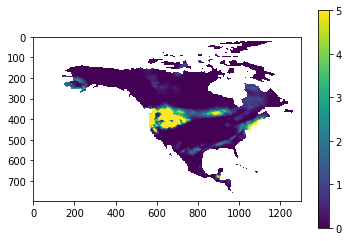

In [115]:
plt.imshow(bma_data[:,:,17])
plt.colorbar()
plt.clim([0,5])